## Imports

In [1]:
from torchvision.transforms.v2.functional import to_pil_image
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd
import torch
import tqdm
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification

import data
import lib

from lib import predict_siglip

import ipywidgets as widgets
from IPython.display import display

## Model instantiation

In [3]:
restore_checkpoint: bool = True

model_id = "google/siglip2-large-patch16-384"  # FixRes вариант
model_preprocessor = AutoImageProcessor.from_pretrained(model_id)  # даст resize/normalize, mean/std/size

optimizer = None

# upcoming training epoch
epoch = 0

if restore_checkpoint:
    epochs = lib.model_checkpoints(f'./models_siglip2/checkpoint_*.pth')

    if len(epochs) == 0:
        print('no models found')
        raise ValueError('No model found')

    print(f'Loading model from epoch { epochs[ 0 ] }')

    checkpoint = torch.load(f'./models_siglip2/checkpoint_{ epochs[ 0 ] }.pth', weights_only=False)

    model = checkpoint['model']
    optimizer = checkpoint['optimizer']

    epoch = model.epoch + 1
else:
    # Веса энкодера + НОВАЯ голова классификации (num_labels=2):
    model = AutoModelForImageClassification.from_pretrained(
        model_id,
        num_labels=len(data.species_labels),
        ignore_mismatched_sizes=True,  # создаст новую голову нужного размера
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    model.tracking_loss = []
    model.tracking_loss_val = []
    model.tracking_accuracy = []
    model.tracking_val_probs = []
    # the last epoch we finished training on
    model.epoch = None

tracking_loss = model.tracking_loss
tracking_loss_val = model.tracking_loss_val
tracking_accuracy = model.tracking_accuracy
tracking_val_probs = model.tracking_val_probs

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading model from epoch 09


## Training

### Data

In [4]:
train_ds = lib.ImageDatasetSigLip2(data.x_train, data.y_train, processor=model_preprocessor, learning=True)
val_ds   = lib.ImageDatasetSigLip2(data.x_eval, data.y_eval, processor=model_preprocessor, learning=False)

train_loader = DataLoader(train_ds, batch_size=96, shuffle=True, num_workers=6)
val_loader   = DataLoader(val_ds,   batch_size=96, shuffle=False, num_workers=6)

### Freezing

In [5]:
unfreezing: Literal['classifier_only', 'classifier_and_encoder', 'all'] = 'classifier_and_encoder'

# C) Параметрические группы с «ступенчатым» LR: у головы LR выше, у энкодера ниже
head_params = []
enc_params  = []

if unfreezing == 'classifier_only':
    # 2) Заморозим всё, кроме головы (линейный пробинг)
    for name, p in model.named_parameters():
        p.requires_grad = "classifier" in name  # у HF-классификаторов голова обычно называется "classifier"

        if "classifier" in name:
            head_params.append(p)

elif unfreezing == 'classifier_and_encoder':
    # A) Сначала всё заморозим
    for p in model.parameters():
        p.requires_grad = False
    for name, p in model.named_parameters():
        if "classifier" in name:
            p.requires_grad = True  # голова остаётся обучаемой
            head_params.append(p)

    # B) Разморозим последние L блоков визуального энкодера
    L = 4  # начните с 2–4; при достаточном VRAM можно 6–8
    layers = model.vision_model.encoder.layers   # ModuleList
    for block in layers[-L:]:
        for p in block.parameters():
            p.requires_grad = True
            enc_params.append(p)
elif unfreezing == 'all':
    for p in model.parameters():
        p.requires_grad = True
else:
    raise ValueError(f"Unknown unfreezing mode: {unfreezing}")

### Loss (possibly with weights)

In [6]:
# 4) Баланс классов (простой вариант: веса в CrossEntropy по частотам)
# import numpy as np
# counts = np.bincount(train_labels, minlength=2)  # counts[0], counts[1]
# class_weights = torch.tensor((counts.sum() / (2.0 * np.maximum(counts, 1))), dtype=torch.float32, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

### Optimizer

In [7]:
if optimizer is None:
    optimizer = torch.optim.AdamW(
        [
            {"params": enc_params,  "lr": 1e-4, "weight_decay": 0.05},
            {"params": head_params, "lr": 1e-3, "weight_decay": 0.01},
        ]
    )

### Cutmix + mixup

In [8]:
from torchvision.transforms import v2

use_cutmix_mixup = True

cutmix = v2.CutMix(num_classes=len(data.species_labels))
mixup = v2.MixUp(num_classes=len(data.species_labels))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

### Loop

In [24]:
stop_button = widgets.Button(description="Stop")
stop_flag = { 'value' : False }

def on_click(b):
    stop_flag['value'] = True

stop_button.on_click(on_click)
display(stop_button)

num_epochs = 5

for cur_epoch in range(epoch, epoch + num_epochs):
    if stop_flag['value']:
        break

    print(f"Starting epoch {cur_epoch}")

    model.train()

    loss_acc = 0
    count = 0

    for batch in tqdm.tqdm(train_loader, total=len(train_loader), desc='Training'):
        optimizer.zero_grad(set_to_none=True)

        images, labels = batch["pixel_values"].to(torch.device("cuda")), batch["labels"].to(torch.device("cuda"))

        if use_cutmix_mixup:
            images, labels = cutmix_or_mixup(images, labels)

        out = model(images)              # logits: (B, 2)
        loss = criterion(out.logits, labels)

        c = batch['pixel_values'].size(0)
        loss_acc += loss.item() * c
        count += c

        loss.backward()
        optimizer.step()

    tracking_loss.append(loss_acc / count)

    # валидация
    model.eval()

    probs, loss_acc = predict_siglip(
        model, val_loader, accumulate_probs=True, accumulate_loss=True, desc='Validation', columns=data.species_labels, criterion=criterion
    )
    tracking_val_probs.append(probs)
    tracking_loss_val.append(loss_acc)

    eval_predictions = probs.idxmax(axis=1)
    eval_true = data.y_eval.idxmax(axis=1)
    correct = (eval_predictions == eval_true).sum()
    accuracy = correct / len(eval_predictions)
    tracking_accuracy.append(accuracy.item())

    model.epoch = cur_epoch
    lib.save_model(model, optimizer, f"./models_siglip2/checkpoint_{str(cur_epoch).rjust(2, "0")}.pth")

    epoch = cur_epoch + 1


Button(description='Stop', style=ButtonStyle())

Starting epoch 15


Validation: 100%|██████████| 35/35 [01:16<00:00,  2.17s/it]


Starting epoch 16


Validation: 100%|██████████| 35/35 [01:16<00:00,  2.17s/it]


Starting epoch 17


Validation: 100%|██████████| 35/35 [01:16<00:00,  2.17s/it]


Starting epoch 18


Validation: 100%|██████████| 35/35 [01:15<00:00,  2.17s/it]


Starting epoch 19


Validation: 100%|██████████| 35/35 [01:15<00:00,  2.17s/it]


## Training progress

In [25]:
tracking_loss, tracking_loss_val, tracking_accuracy

([1.9612920373745992,
  1.7955801764973371,
  1.743362732833764,
  1.7622568443022144,
  1.7415640653128692,
  1.7052439401328698,
  1.6987801781199574,
  1.6653754268477052,
  1.699083335802716,
  1.7024058001614413,
  1.7273468308416255,
  1.5487944437392829,
  1.5429765633871557,
  1.4906101128294036,
  1.4490017281598082,
  1.4078301873145636,
  1.4199405600574542,
  1.358574344770216,
  1.383562191152681,
  1.372197279449301],
 [1.6875934751197164,
  1.6314184495071125,
  1.528109800533644,
  1.5419796208600842,
  1.4875619192424148,
  1.486066356942898,
  1.4712149890138568,
  1.4327974512477295,
  1.4394049758691365,
  1.4238667596535945,
  1.2407201282033926,
  1.2646427271653842,
  1.1279765579323107,
  1.188750013067478,
  1.197835712161044,
  1.1090260711563509,
  1.2258610968303507,
  1.2108237552527155,
  1.2219552291097462,
  1.139507223867228],
 [0.4696785930867192,
  0.47058823529411764,
  0.4960582171012735,
  0.47058823529411764,
  0.48635536688902364,
  0.45815645845

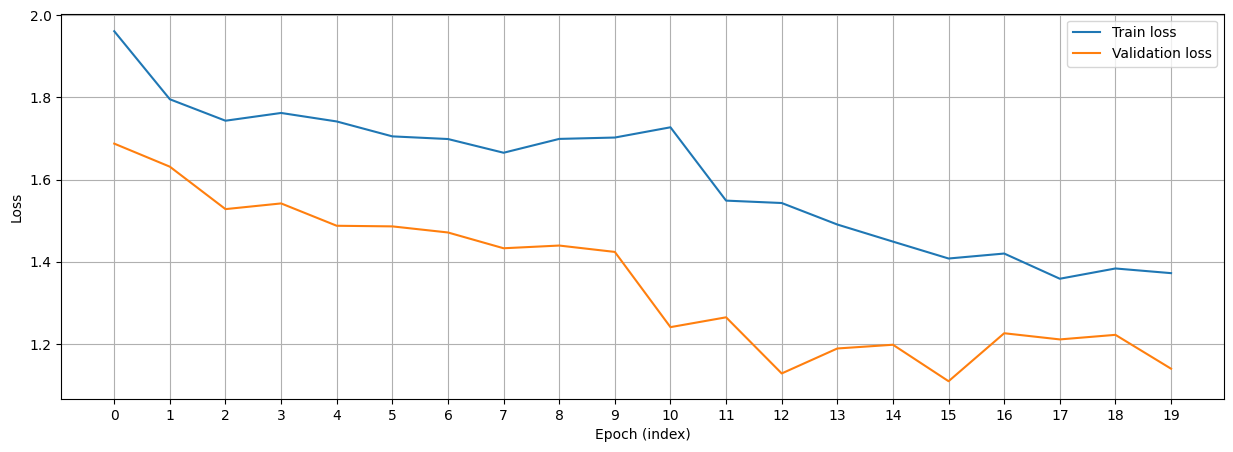

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

epochs_train = list(range(len(tracking_loss)))
epochs_val = list(range(len(tracking_loss_val)))

line1, = ax.plot(epochs_train, tracking_loss, label="Train loss")
line2, = ax.plot(epochs_val, tracking_loss_val, label="Validation loss")

ax.set_xlabel("Epoch (index)")
ax.set_ylabel("Loss")
ax.legend(loc="best", handles=[line1, line2])

ax.set_xticks(epochs_train)

ax.grid(True)

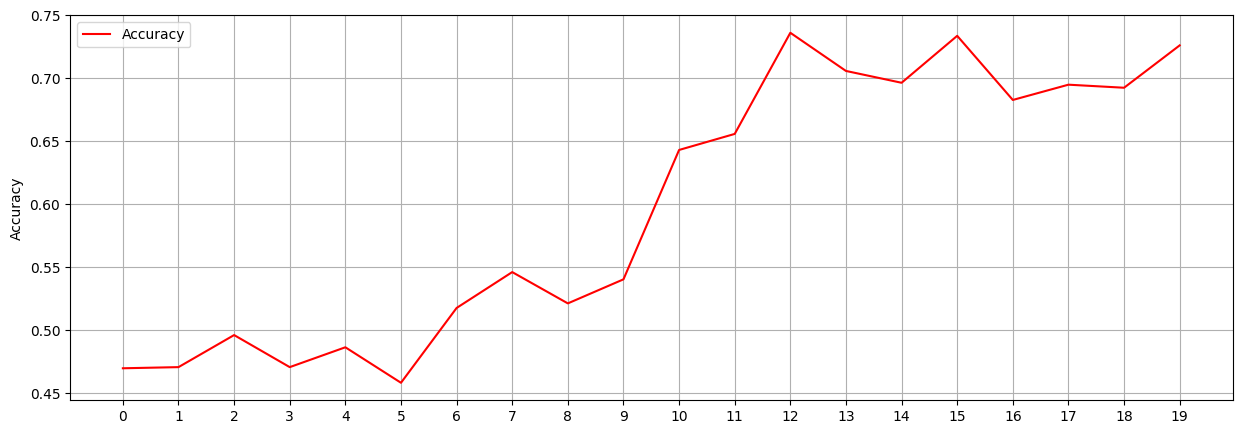

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

epochs_accuracy = list(range(len(tracking_accuracy)))

line1, = ax.plot(epochs_accuracy, tracking_accuracy, label="Accuracy", color="red")
ax.set_ylabel("Accuracy")

ax.legend(loc="best", handles=[line1])

ax.set_xticks(epochs_train)

ax.grid(True)

## Validation

In [28]:
eval_preds_df = tracking_val_probs[-1]

In [29]:
print("True labels (training):")
data.y_train.idxmax(axis=1).value_counts(normalize=True)

True labels (training):


monkey_prosimian    0.172328
blank               0.157544
antelope_duiker     0.151554
rodent              0.123730
leopard             0.116452
bird                0.112585
civet_genet         0.108870
hog                 0.056937
Name: proportion, dtype: float64

In [30]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts(normalize=True)

Predicted labels (eval):


civet_genet         0.283505
blank               0.166768
antelope_duiker     0.149788
leopard             0.146756
monkey_prosimian    0.083384
hog                 0.072771
rodent              0.058520
bird                0.038508
Name: proportion, dtype: float64

In [31]:
print("True labels (eval):")
data.y_eval.idxmax(axis=1).value_counts(normalize=True)

True labels (eval):


civet_genet         0.299272
leopard             0.217708
antelope_duiker     0.144027
rodent              0.115525
hog                 0.068830
monkey_prosimian    0.066404
bird                0.047301
blank               0.040934
Name: proportion, dtype: float64

In [32]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_true = data.y_eval.idxmax(axis=1)

In [33]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy.item()

0.7261976955730746

In [56]:
eval_preds = eval_preds_df.copy()

eval_preds[ 'cls' ] = eval_preds_df.idxmax(axis=1)
eval_preds[ 'cls_true' ] = data.y_eval.idxmax(axis=1)

eval_preds[(eval_preds[ 'cls' ] == 'blank') & (eval_preds[ 'cls_true' ] == 'leopard')]

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,cls,cls_true
ZJ000244,0.063787,0.005324,0.822731,0.022189,0.022650,0.013088,0.005781,0.044451,blank,leopard
ZJ000293,0.084306,0.067451,0.594478,0.046460,0.018688,0.123218,0.026335,0.039063,blank,leopard
ZJ000515,0.089657,0.013307,0.798169,0.037635,0.010672,0.010946,0.012862,0.026752,blank,leopard
ZJ000520,0.095589,0.003508,0.828942,0.016890,0.007080,0.017974,0.006087,0.023931,blank,leopard
ZJ000661,0.148512,0.006373,0.490399,0.055228,0.167963,0.065311,0.033955,0.032260,blank,leopard
...,...,...,...,...,...,...,...,...,...,...
ZJ015973,0.043515,0.006021,0.803309,0.038606,0.023914,0.028868,0.014047,0.041720,blank,leopard
ZJ016047,0.100710,0.004166,0.740643,0.023482,0.025251,0.021910,0.013636,0.070202,blank,leopard
ZJ016396,0.154546,0.009977,0.236417,0.185535,0.198981,0.138466,0.041563,0.034516,blank,leopard
ZJ016411,0.122841,0.008846,0.409469,0.037586,0.061436,0.302580,0.039754,0.017488,blank,leopard


In [61]:
rows = eval_preds[(eval_preds[ 'cls' ] == 'blank') & (eval_preds[ 'cls_true' ] == 'leopard')]
list(rows.iterrows())

[('ZJ000244',
  antelope_duiker     0.063787
  bird                0.005324
  blank               0.822731
  civet_genet         0.022189
  hog                  0.02265
  leopard             0.013088
  monkey_prosimian    0.005781
  rodent              0.044451
  cls                    blank
  cls_true             leopard
  Name: ZJ000244, dtype: object),
 ('ZJ000293',
  antelope_duiker     0.084306
  bird                0.067451
  blank               0.594478
  civet_genet          0.04646
  hog                 0.018688
  leopard             0.123218
  monkey_prosimian    0.026335
  rodent              0.039063
  cls                    blank
  cls_true             leopard
  Name: ZJ000293, dtype: object),
 ('ZJ000515',
  antelope_duiker     0.089657
  bird                0.013307
  blank               0.798169
  civet_genet         0.037635
  hog                 0.010672
  leopard             0.010946
  monkey_prosimian    0.012862
  rodent              0.026752
  cls                 

In [93]:
import math
from itertools import zip_longest
from PIL import Image
%matplotlib notebook
from torchvision.transforms.functional import to_pil_image

random_state = 4111

rows = eval_preds[(eval_preds[ 'cls' ] == 'blank') & (eval_preds[ 'cls_true' ] == 'leopard')]

rows = rows.sample(frac=0.5, random_state=random_state)

n_cols = 2
n_rows = math.ceil(len(rows) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 85))
fig.tight_layout()

# iterate through each species
print(f'Total rows: {len(rows)}')

clahe = lib.LabCLAHE()

for row, ax in zip_longest(list(rows.iterrows()), axes.flatten()):
    if row is None:
        if ax is not None:
            ax.remove()
        continue
    if ax is None:
        break
    img = Image.open('data/train_features/' + row[0] + '.jpg')
    ax.imshow(to_pil_image(clahe(clahe(img))))
    ax.set_title(f"{row[1].name} ")

<IPython.core.display.Javascript object>

Total rows: 74


### Confusion matrix

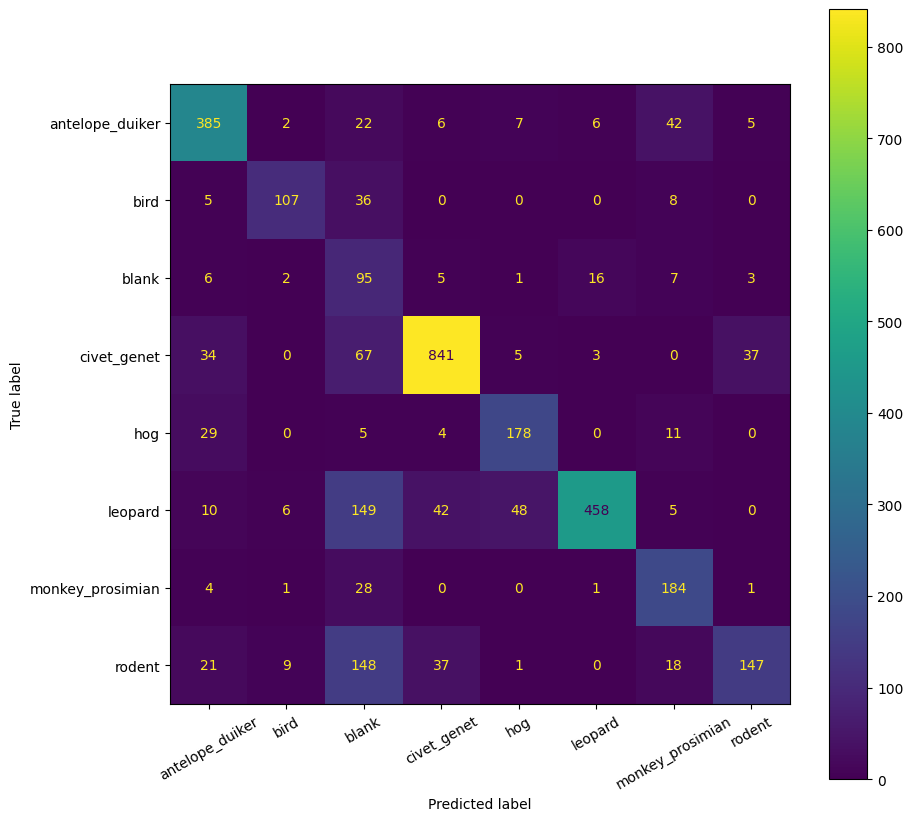

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    data.y_eval.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=30,
    colorbar=True,
)

## Create submission

In [35]:
test_dataset = lib.ImageDatasetSigLip2(data.test_features, processor=model_preprocessor, learning=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6)

In [36]:
submission_df, _ = predict_siglip(model, test_dataloader, columns=data.species_labels)

Predicting: 100%|██████████| 140/140 [01:46<00:00,  1.32it/s]


In [37]:
submission_format = pd.read_csv("data/submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

In [38]:
submission_df.to_csv("submission.csv")